In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import os
import bz2
from scipy import ndimage
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import matplotlib.patches as patches

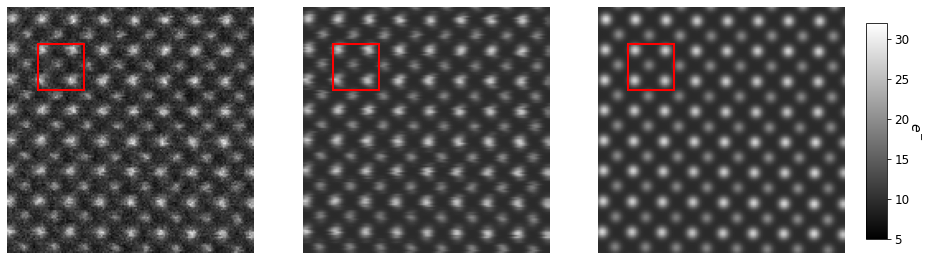

In [19]:
# Read data
# Panel 1: fitted peaks, peaks with deformations, and raw data
path = 'D:/2020/JDDC/DeformationVisulization/10Frames_B1_sym/'
# path = 'D:/2020/JDDC/DoseTest_exp/10Frames/10Frames_B1_WrongInitialization/'
image = loadFromQ2bz(path + 'bump-0_003.q2bz')
defX = loadFromQ2bz(path + "bump-0_003-y_0.q2bz")
defY = loadFromQ2bz(path + "bump-0_003-y_1.q2bz")
exp = loadFromQ2bz(path + "u0_000.q2bz")

deformed_image = deformImage(image, defX, defY, order=1, mode='nearest')

# Save and display the result
fig = plt.figure(figsize=[15,5])

ax = plt.subplot(133)
plt.imshow(image, cmap=plt.cm.gray,clim=[5,32])
# plt.colorbar()
rect = patches.Rectangle((18,22),28,28,linewidth=2,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.axis('off')

ax = plt.subplot(132)
plt.imshow(deformed_image, cmap=plt.cm.gray,clim=[5,32])
rect = patches.Rectangle((18,22),28,28,linewidth=2,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.axis('off')

ax = plt.subplot(131)
im = plt.imshow(exp, cmap=plt.cm.gray,clim=[5,32])
rect = patches.Rectangle((18,22),28,28,linewidth=2,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.axis('off')
# plt.show()

cax = fig.add_axes([0.92,0.2,0.02,0.6])
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('$e^{-}$',rotation=270,fontsize=14, labelpad = 12)

fig.savefig('D:/2020/JDDC/DeformationVisulization/Panel1.tif')

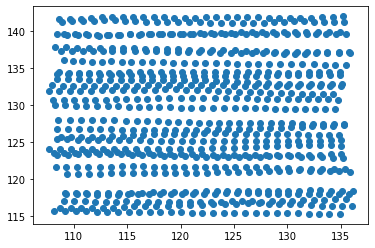

In [13]:
coords = np.mgrid[0:image.shape[0], 0:image.shape[1]] + np.multiply([defY, defX], (np.max(image.shape)-1))
plt.scatter(coords[1,115:143,108:136],coords[0,115:143,108:136])

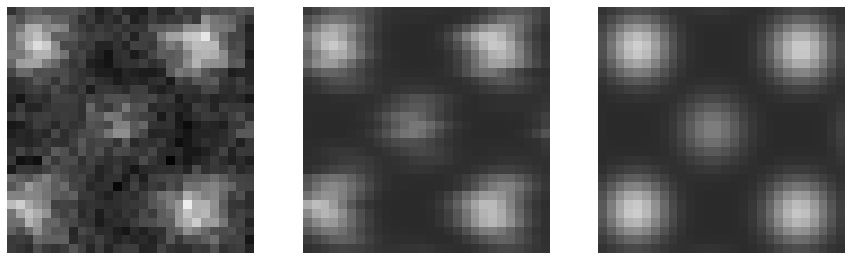

In [26]:
# Panel 2: Zoomed in on a small patch, deformation vectors, deformed image, and raw data
fig = plt.figure(figsize=[15,5])

plt.subplot(133)
plt.imshow(image[22:50,18:46], cmap=plt.cm.gray,clim=[5,32])
plt.axis('off')

plt.subplot(132)
plt.imshow(deformed_image[22:50,18:46], cmap=plt.cm.gray,clim=[5,32])
plt.axis('off')

plt.subplot(131)
im = plt.imshow(exp[22:50,18:46], cmap=plt.cm.gray,clim=[5,32])
plt.axis('off')
fig.savefig('D:/2020/JDDC/DeformationVisulization/Panel2.tif')

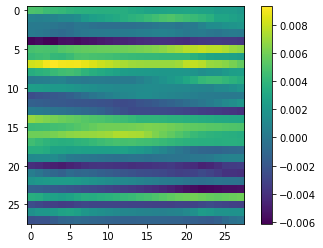

In [27]:
plt.imshow(step_Y[115:143,108:136])
plt.colorbar()

In [28]:
# Split deformation into row displacement and sample drift
row_def_X = []
row_def_Y = []
drift_X = defX[:]
drift_Y = defY[:]
step_X = defX[:]
step_Y = defY[:]

for i in range(1,defX.shape[0]):
    row_def_X.append(defX[i,0] - defX[i-1,-0])
    row_def_Y.append(defY[i,0] - defY[i-1,-0])
    drift_X[i,:] = drift_X[i,:] - (defX[i,0] - defX[i-1,-0])
    drift_Y[i,:] = drift_Y[i,:] - (defY[i,0] - defY[i-1,-0])
    step_X[i,0:-1] = drift_X[i,1::] - drift_X[i,0:-1]
    step_Y[i,0:-1] = drift_Y[i,1::] - drift_Y[i,0:-1]

step_X = step_X[:,0:-1]
step_Y = step_Y[:,0:-1]

ValueError: assignment destination is read-only

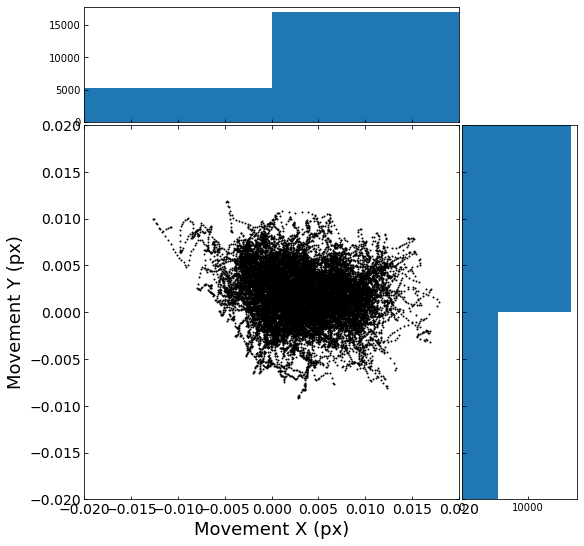

In [29]:
x, y = step_X[1:-1].flatten(), step_Y[1:-1].flatten()

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.scatter(x, y,s=1,color='black')
ax_scatter.set_xlabel('Movement X (px)',fontsize=18)
ax_scatter.set_ylabel('Movement Y (px)',fontsize=18)
ax_scatter.tick_params(direction='in',labelsize = 14)

# now determine nice limits by hand:
binwidth = 0.02
lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
ax_scatter.set_xlim((-lim, lim))
ax_scatter.set_ylim((-lim, lim))

bins = np.arange(-lim, lim + binwidth, binwidth)
ax_histx.hist(x, bins=bins)
ax_histy.hist(y, bins=bins, orientation='horizontal')

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

plt.show()

(-0.15, 0.15)

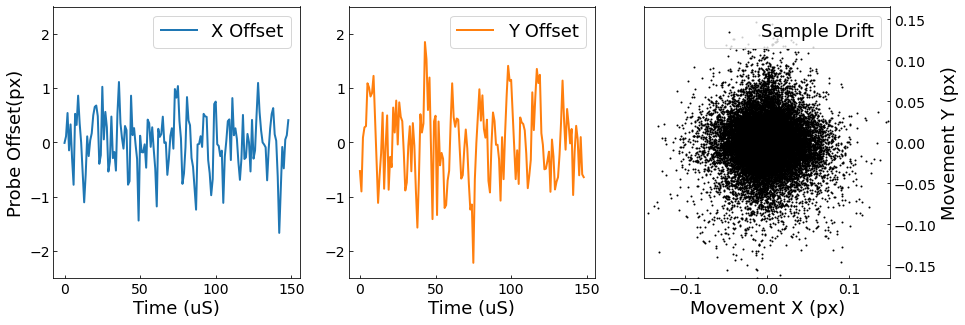

In [60]:
# Panel 3: line offset along x and y, sample random drift
fig = plt.figure(figsize=[15,5])

plt.subplot(131)
plt.plot(row_def_X - np.mean(row_def_X), linewidth = 2, label = 'X Offset')
# plt.plot(row_def_X)
plt.ylim([-2.5,2.5])
plt.xlabel('Time (uS)',fontsize=18)
plt.ylabel('Probe Offset(px)',fontsize=18)
plt.legend(fontsize = 18)
plt.tick_params(direction='in',labelsize = 14)

plt.subplot(132)
plt.plot(row_def_Y - np.mean(row_def_Y),color='#ff7f0e',linewidth = 2, label = 'Y Offset')
plt.ylim([-2.5,2.5])
plt.xlabel('Time (uS)',fontsize=18)
plt.legend(fontsize = 18)
plt.tick_params(direction='in',labelsize = 14)

ax = plt.subplot(133)
plt.scatter(step_X[1:-1,1:-1],step_Y[1:-1,1:-1],s=1,color='black', label = 'Sample Drift')
plt.axis('equal')
plt.xlabel('Movement X (px)',fontsize=18)
plt.ylabel('Movement Y (px)',fontsize=18)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
plt.legend(fontsize = 18)
plt.tick_params(direction='in',labelsize = 14)
# plt.xlim([-2,2])
# plt.ylim([-2,2])
plt.xlim([-0.15,0.15])
plt.ylim([-0.15,0.15])

# fig.savefig('D:/2020/JDDC/DeformationVisulization/Panel3.tif')

In [4]:
def loadFromQ2bz(path):
    filename, file_extension = os.path.splitext(path)

    if(file_extension == '.q2bz' or file_extension == '.bz2'):
        fid = bz2.open(path, 'rb')
    else:
        fid = open(path, 'rb')
    # Read magic number
    line = fid.readline().rstrip().decode('ascii')
    if(line[0] != 'P'):
        quit("Invalid array header, doesn't start with 'P'")
    if(line[1] != '9'):
        quit("Invalid data type, only double is supported currently")
    fid.readline().rstrip()  # Skip header

    # Read width and height
    arr = fid.readline().rstrip().split()
    width = int(arr[0])
    height = int(arr[1])

    # Read max, but be careful not to read more than one new line after max.
    # The binary data could start with a value that is equivalent to a
    # new line.
    max = ""
    while True:
        c = fid.read(1)
        if c == b'\n':
            break
        max = max + str(int(c))

    max = int(max)

    # Read image to vector
    x = np.frombuffer(fid.read(), np.float64)
    img = x.reshape(width, height)
    return img

In [2]:
def deformImage(image, displacementX, displacementY, order=1, mode='nearest', cval=0.0):
    # Convert the displacement to a coordinate system
    coords = np.mgrid[0:image.shape[0], 0:image.shape[1]] \
             + np.multiply([displacementY, displacementX], (np.max(image.shape)-1))

    # Resample the image at the coordinates obtained from the displacement to deform the image
    return ndimage.map_coordinates(image, coords, order=order, mode=mode, cval=cval)